In [1]:
import pandas as pd

In [2]:
import sklearn; sklearn.show_versions()


System:
    python: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
executable: /opt/anaconda3/bin/python
   machine: macOS-15.2-arm64-arm-64bit

Python dependencies:
      sklearn: 1.4.2
          pip: 24.0
   setuptools: 69.5.1
        numpy: 1.26.4
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.8.4
       joblib: 1.4.2
threadpoolctl: 2.2.0

Built with OpenMP: True

threadpoolctl info:
       filepath: /opt/anaconda3/lib/libopenblasp-r0.3.21.dylib
         prefix: libopenblas
       user_api: blas
   internal_api: openblas
        version: 0.3.21
    num_threads: 10
threading_layer: pthreads
   architecture: armv8

       filepath: /opt/anaconda3/lib/libomp.dylib
         prefix: libomp
       user_api: openmp
   internal_api: openmp
        version: None
    num_threads: 10


In [3]:
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
import matplotlib.pyplot as plt

In [6]:
train = pd.read_csv('train.csv', index_col=0)

In [7]:
train

,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
5,18,2022-07-29 09:10:34,10
...,...,...,...
37512,6,2022-12-31 17:21:19,10
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6


In [8]:
test = pd.read_csv('test.csv', index_col=0)

In [9]:
test

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


In [10]:
all_data = pd.concat([train, test], axis=0)

In [11]:
all_data

,user_id,ts,gate_id,lost_id
0,18.0,2022-07-29 09:08:54,7,NaN
1,18.0,2022-07-29 09:09:54,9,NaN
3,18.0,2022-07-29 09:10:06,5,NaN
4,18.0,2022-07-29 09:10:08,5,NaN
5,18.0,2022-07-29 09:10:34,10,NaN
...,...,...,...,...
44637,NaN,2023-02-24 17:08:57,10,15.0
44638,NaN,2023-02-24 19:43:36,11,15.0
44639,NaN,2023-02-24 19:44:00,4,15.0
44640,NaN,2023-02-24 19:44:01,4,15.0


In [14]:
# Доля тест во всей выборке

sum(all_data['lost_id'].notnull()) / all_data['lost_id'].shape[0] 

0.15840352220520673

In [15]:
all_data['ts'] = pd.to_datetime(all_data['ts'])

In [16]:
test['ts'] = pd.to_datetime(test['ts'])

<Axes: >

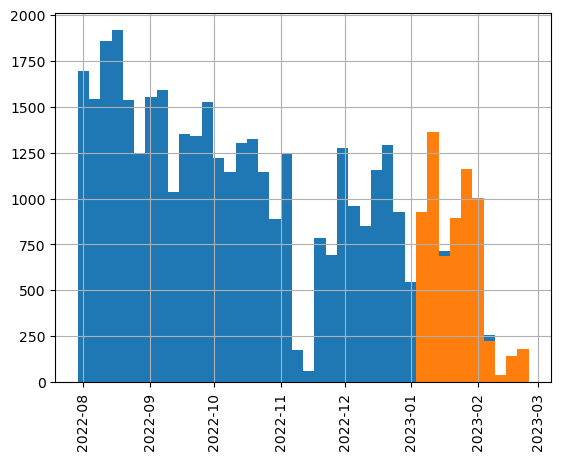

In [17]:
plt.figure()
plt.xticks(rotation='vertical')
all_data['ts'].hist(bins=40)
test['ts'].hist(bins=10)

In [18]:
all_data['lost_id'].value_counts().count()

34

# Here we continue

In [19]:
train_gate_list = sorted(list(train['gate_id'].unique()))

In [20]:
test_gate_list = sorted(list(test['gate_id'].unique()))

In [21]:
only_test = [gate for gate in test_gate_list if gate not in train_gate_list]

In [22]:
only_test

[2]

In [23]:
test[test['gate_id']==2]

,ts,gate_id,lost_id
39911,2023-01-13 16:49:52,2,33
39912,2023-01-13 16:49:54,2,33
39928,2023-01-13 18:21:16,2,33
39929,2023-01-13 18:21:19,2,33


In [24]:
all_gates = sorted(list(all_data['gate_id'].unique()))
all_gates

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [25]:
# Составим список турникетов вида "gate_номер"

list_gate_vars = ['gate_'+str(i) for i in all_gates]

In [26]:
# Теперь: cделаем бинарные переменные

new_vals = pd.get_dummies(all_data['gate_id']).values 

In [27]:
# Припишем новые бинарные переменные "турникет" к полной выборке

all_data[list_gate_vars] = new_vals

In [28]:
# Список дней недели

list_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

In [29]:
# Припишем новые бинарные переменные "день недели" к полной выборке

all_data[list_dow] = pd.get_dummies(all_data['ts'].dt.day_name())[list_dow].values

In [30]:
all_data['ts'].dt.day_name().value_counts()

ts
Friday       8894
Thursday     8371
Wednesday    8066
Monday       7809
Tuesday      7642
Saturday      687
Sunday        323
Name: count, dtype: int64

In [31]:
all_data['hour'] = all_data['ts'].dt.hour.values

In [32]:
# Список переменных вида "hour_час в полной выборке"

list_hours = ['hour_'+str(i) for i in sorted(list(all_data['ts'].dt.hour.unique()))] 

In [33]:
# Добавим бинарные переменные для месяца

all_data[list_hours] = pd.get_dummies(all_data['ts'].dt.hour.values).values

In [34]:
all_data['min'] = all_data['ts'].dt.minute.values

In [35]:
all_data['day'] = all_data['ts'].dt.day.values

In [36]:
all_data['month'] = all_data['ts'].dt.month.values

In [37]:
all_data['dayofweek'] = all_data['ts'].dt.dayofweek.values

In [38]:
all_data.columns

Index(['user_id', 'ts', 'gate_id', 'lost_id', 'gate_-1', 'gate_0', 'gate_1',
       'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8',
       'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14',
       'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'hour', 'hour_0', 'hour_1', 'hour_3',
       'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'min', 'day',
       'month', 'dayofweek'],
      dtype='object')

In [39]:
train['ts'].agg(['max','count'])

max      2022-12-31 20:39:31
count                  35172
Name: ts, dtype: object

In [40]:
test['ts'].agg(['min','max','count'])

min      2023-01-03 08:21:00
max      2023-02-24 19:44:09
count                   6620
Name: ts, dtype: object

# Val index

In [41]:
val_index = train['ts'] > '2022-11-30'

In [42]:
sum(val_index) / val_index.shape[0]

0.18614238598885477

In [43]:
all_data.head(2)

,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
0,18.0,2022-07-29 09:08:54,7,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,8,29,7,4
1,18.0,2022-07-29 09:09:54,9,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,9,29,7,4


In [45]:
train_idx = all_data['lost_id'].isnull()
train = all_data.loc[train_idx]
test = all_data.loc[~train_idx]

In [48]:
display(train.tail(1), test.head(1))

,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
37516,6.0,2022-12-31 20:39:31,9,NaN,False,False,False,False,False,False,...,False,False,True,False,False,False,39,31,12,5


,user_id,ts,gate_id,lost_id,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
37518,NaN,2023-01-03 08:21:00,9,1.0,False,False,False,False,False,False,...,False,False,False,False,False,False,21,3,1,1


In [49]:
X = train[~val_index].copy()
X_val = train[val_index].copy()

y = X['user_id'].astype(int)
y_val = X_val['user_id'].astype(int)

In [50]:
cols_cat = list(all_data.columns[4:])

In [51]:
X = X[cols_cat].astype(int)
X_val = X_val[cols_cat].astype(int)

In [52]:
X

,gate_-1,gate_0,gate_1,gate_2,gate_3,gate_4,gate_5,gate_6,gate_7,gate_8,...,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,min,day,month,dayofweek
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,8,29,7,4
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9,29,7,4
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,10,29,7,4
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,10,29,7,4
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,29,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30529,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,45,29,11,1
30530,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,46,29,11,1
30531,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,50,29,11,1
30532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,50,29,11,1


In [53]:
# Сделаем нормирование отдельными скейлерами по X и по X_val, т.к. будущие данные скорее всего изменятся

scaler_X = StandardScaler()
scaler_X_val = StandardScaler()

scaler_X.fit(X)
scaler_X_val.fit(X_val)

X_scaled = scaler_X.transform(X)
X_val_scaled = scaler_X_val.transform(X_val)

In [55]:
print('Признаки, всего', len(X.columns))
print(list(X.columns))

Признаки, всего 51
['gate_-1', 'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14', 'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'min', 'day', 'month', 'dayofweek']


In [56]:
clf = LogisticRegression(random_state=1,solver='saga').fit(X_scaled, y)

y_pred = clf.predict(X_scaled)

y_val_pred = clf.predict(X_val_scaled)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [70]:
results = pd.DataFrame(y_val)
results['pred'] = y_val_pred
results

,user_id,pred
30535,1,3
30536,1,18
30538,1,18
30539,1,18
30540,1,18
...,...,...
37512,6,37
37513,6,29
37514,6,33
37515,6,33


In [78]:
results['user_id'].unique().shape

(43,)

In [74]:
test_orig = pd.read_csv('test.csv', index_col=0)
test_orig

,ts,gate_id,lost_id
37518,2023-01-03 08:21:00,9,1
37520,2023-01-03 08:21:18,5,1
37521,2023-01-03 08:21:19,5,1
37522,2023-01-03 08:21:39,10,1
37523,2023-01-03 08:32:49,15,19
...,...,...,...
44637,2023-02-24 17:08:57,10,15
44638,2023-02-24 19:43:36,11,15
44639,2023-02-24 19:44:00,4,15
44640,2023-02-24 19:44:01,4,15


In [87]:
import numpy as np

In [100]:
# Предскажем самым частотным user_id на val

def mode_1(x):
    return x.mode().iloc[0]

res = results.groupby('user_id')['pred'].agg([mode_1, 'count']) 
display(res)

res = res.reset_index(); del res['count']

,mode_1,count
user_id,,
0,55,286
1,1,325
2,55,39
3,3,179
5,31,6
6,37,272
9,12,142
10,11,17
11,37,239


In [107]:
print('correct', (res['user_id'] == res['mode_1']).sum())
print('out of', res.shape[0])
print('or', int((res['user_id'] == res['mode_1']).sum()*100 / res.shape[0]), '%')

correct 5
out of 43
or 11 %


In [116]:
# Train предсказуемо имеет более высокую метрику

results2 = pd.DataFrame(y)
results2['pred'] = y_pred
res2 = results2.groupby('user_id')['pred'].agg([mode_1]).reset_index()

print('correct', (res2['user_id'] == res2['mode_1']).sum())
print('out of', res2.shape[0])
print('or', int((res2['user_id'] == res2['mode_1']).sum()*100 / res2.shape[0]), '%')

correct 13
out of 50
or 26 %


In [66]:
# На реальном тесте в задаче можно ожидать около 10% правильных ответом таким наивным подходом 
# (но из-за весов значение метрики будет другим) 

In [117]:
test['lost_id']

37518     1.0
37520     1.0
37521     1.0
37522     1.0
37523    19.0
         ... 
44637    15.0
44638    15.0
44639    15.0
44640    15.0
44641    15.0
Name: lost_id, Length: 6620, dtype: float64

In [118]:
X = train.copy()
y = X['user_id'].astype(int)
X_test = test.copy()

In [119]:
X = X[cols_cat].astype(int)
X_test = X_test[cols_cat].astype(int)

In [120]:
# Сделаем нормирование отдельными скейлерами по X и по X_test, т.к. будущие данные скорее всего изменятся

scaler_X = StandardScaler()
scaler_X_test = StandardScaler()

scaler_X.fit(X)
scaler_X_test.fit(X_test)

X_scaled = scaler_X.transform(X)
X_test_scaled = scaler_X_test.transform(X_test)

In [124]:
print('Признаки, всего')
print(len(X.columns))
print(list(X.columns))

Признаки, всего
51
['gate_-1', 'gate_0', 'gate_1', 'gate_2', 'gate_3', 'gate_4', 'gate_5', 'gate_6', 'gate_7', 'gate_8', 'gate_9', 'gate_10', 'gate_11', 'gate_12', 'gate_13', 'gate_14', 'gate_15', 'gate_16', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'hour', 'hour_0', 'hour_1', 'hour_3', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'min', 'day', 'month', 'dayofweek']


In [125]:
clf = LogisticRegression(random_state=1,solver='saga').fit(X_scaled, y)

y_pred = clf.predict(X_scaled)

y_test_pred = clf.predict(X_test_scaled)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [128]:
answer = pd.DataFrame()

answer['lost_id'] = test['lost_id']
answer['preds'] = y_test_pred

In [129]:
answer

,lost_id,preds
37518,1.0,18
37520,1.0,15
37521,1.0,15
37522,1.0,18
37523,19.0,1
...,...,...
44637,15.0,14
44638,15.0,17
44639,15.0,17
44640,15.0,17


In [137]:
# Предскажем самым частотным user_id

submit = pd.DataFrame(answer.groupby('lost_id')['preds'].agg([mode_1]))

In [144]:
submit.index = submit.index.astype(int)
submit.rename(columns={'mode_1':'preds'}, inplace=True)
submit

,preds
lost_id,
0,12
1,15
3,37
6,55
9,53
11,3
12,12
14,12
15,12


In [139]:
submit.shape[0]

34

In [135]:
submit.to_csv('answer.csv') 
! zip answer_base.zip answer.csv

# Получится на борде 58, при равенстве весов (что не так), получилось бы 58 / (560/34) = 3.5,
# примерно 10% правильных user_id (но наверное больше, т.к. отгадали самые дешёвые). 560 = max в задаче.

  adding: answer.csv (deflated 44%)
